In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

sys.path.append("../") 
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

Using device: cuda


In [3]:
valLoader = nnexp.downloadImageNet(batchSize=500)

In [4]:
alexnet = models.AlexNet(pDropout=0)
alexnet.to(DEVICE);

In [5]:
numCorrect = 0
num1 = 0
num5 = 0
numAttempted = 0
alignment = []
for batch in tqdm(valLoader):
    images, label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    
    # Perform forward pass
    outputs = alexnet(images)
    alignment.append(alexnet.measureAlignment(images))
    
    # Measure performance
    sortPred = torch.argsort(outputs, dim=1, descending=True)
    num1 += torch.sum(sortPred[:,0]==label)
    num5 += torch.sum(torch.any(sortPred[:,:5]==label[:,None], dim=1))
    numCorrect += torch.sum(torch.argmax(outputs,axis=1)==label)
    numAttempted += images.shape[0]

# Report performance
print(f"acc@1: {100*num1/numAttempted:.3f}%")
print(f"acc@5: {100*num5/numAttempted:.3f}%")

# Get summary statistics
numLayers = len(alignment[0])
alignMean = models.AlexNet.avgFromFull(alignment)
alignLayer = []
for layer in range(numLayers):
    alignLayer.append(models.AlexNet.layerFromFull(alignment, layer))

# Define dropout indices for each layer
dropoutFraction = 0.25
doIdxHi = []
doIdxLo = []
for layer in range(numLayers):
    idxAlignment = torch.argsort(torch.mean(alignLayer[layer],dim=1))
    numNeurons = len(idxAlignment)
    num2drop = int(numNeurons * dropoutFraction)
    doIdxHi.append(idxAlignment[-num2drop:])
    doIdxLo.append(idxAlignment[:num2drop])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:33<00:00,  3.33s/it]


In [48]:
# Define dropout indices for each layer
dropoutFraction = 0.9
doIdxHi = []
doIdxLo = []
for layer in range(numLayers):
    idxAlignment = torch.argsort(torch.mean(alignLayer[layer],dim=1))
    numNeurons = len(idxAlignment)
    num2drop = int(numNeurons * dropoutFraction)
    doIdxHi.append(idxAlignment[-num2drop:])
    doIdxLo.append(idxAlignment[:num2drop])

In [49]:
num1 = 0
num5 = 0
numAttempted = 0
doNumNoHi1 = np.zeros(numLayers-1)
doNumNoHi5 = np.zeros(numLayers-1)
doNumNoLo1 = np.zeros(numLayers-1)
doNumNoLo5 = np.zeros(numLayers-1)
for batch in tqdm(valLoader):
    images, label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    numAttempted += images.shape[0]
    
    # Perform forward pass
    outputs = alexnet(images)
    
    # Measure performance with full network
    sortPred = torch.argsort(outputs, dim=1, descending=True)
    num1 += torch.sum(sortPred[:,0]==label)
    num5 += torch.sum(torch.any(sortPred[:,:5]==label[:,None], dim=1))
    
    # Measure performance with dropout in each layer
    for layer in range(numLayers-1):
        outNoHi = alexnet.targetedDropout(alexnet,images,idx=doIdxHi[layer],layer=layer)
        sortPred = torch.argsort(outNoHi, dim=1, descending=True)
        doNumNoHi1[layer] += torch.sum(sortPred[:,0]==label)
        doNumNoHi5[layer] += torch.sum(torch.any(sortPred[:,:5]==label[:,None], dim=1))
        
        outNoLo = alexnet.targetedDropout(alexnet,images,idx=doIdxLo[layer],layer=layer)
        sortPred = torch.argsort(outNoLo, dim=1, descending=True)
        doNumNoLo1[layer] += torch.sum(sortPred[:,0]==label)
        doNumNoLo5[layer] += torch.sum(torch.any(sortPred[:,:5]==label[:,None], dim=1))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


In [50]:
acc1 = 100*num1/numAttempted
acc5 = 100*num5/numAttempted
doAccNoHi1 = 100*doNumNoHi1/numAttempted
doAccNoHi5 = 100*doNumNoHi5/numAttempted
doAccNoLo1 = 100*doNumNoLo1/numAttempted
doAccNoLo5 = 100*doNumNoLo5/numAttempted

Text(0, 0.5, 'Acc@5')

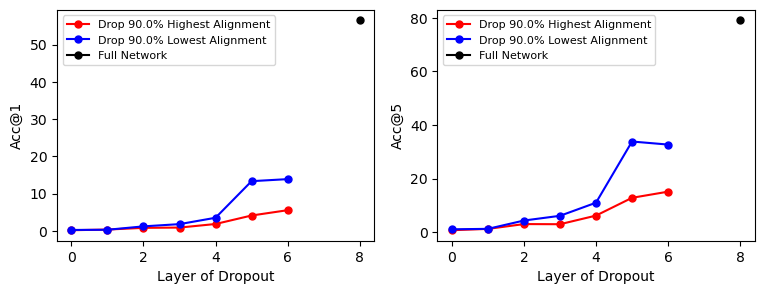

In [51]:
mrkSize = 10

fig,ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(range(numLayers-1), doAccNoHi1, c='r', marker='.', markersize=mrkSize, label=f'Drop {100*dropoutFraction}% Highest Alignment')
ax[0].plot(range(numLayers-1), doAccNoLo1, c='b', marker='.', markersize=mrkSize, label=f'Drop {100*dropoutFraction}% Lowest Alignment')
ax[0].plot(numLayers, acc1.cpu(), c='k', marker='.', markersize=mrkSize, label='Full Network')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Layer of Dropout')
ax[0].set_ylabel('Acc@1')

ax[1].plot(range(numLayers-1), doAccNoHi5, c='r', marker='.', markersize=mrkSize, label=f'Drop {100*dropoutFraction}% Highest Alignment')
ax[1].plot(range(numLayers-1), doAccNoLo5, c='b', marker='.', markersize=mrkSize, label=f'Drop {100*dropoutFraction}% Lowest Alignment')
ax[1].plot(numLayers, acc5.cpu(), c='k', marker='.', markersize=mrkSize, label='Full Network')
ax[1].legend(fontsize=8)
ax[1].set_xlabel('Layer of Dropout')
ax[1].set_ylabel('Acc@5')
